# https://www.kaggle.com/txp142130/utd-crimes-in-chicago-with-choropleth-map

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import folium
from folium import IFrame, FeatureGroup, LayerControl, Map, Marker, plugins
import seaborn as sns
import matplotlib.pyplot as plt

Chicago_COORDINATES = (41.895140898, -87.624255632)

#crimes1 = pd.read_csv('../input/crimes-in-chicago/Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes2 = pd.read_csv('data/chicago/Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes3 = pd.read_csv('data/chicago/Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False)
crimes4 = pd.read_csv('data/chicago/Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)
crimedata = pd.concat([crimes2, crimes3, crimes4], ignore_index=False, axis=0)

#Deleting dataframe as they are no longer needed.
del crimes2
del crimes3
del crimes4
#crimes4

crimedata.head()

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


Unnamed: 0       ID Case Number                    Date  \
0           0  4673626    HM274058  04/02/2006 01:00:00 PM   
1           1  4673627    HM202199  02/26/2006 01:40:48 PM   
2           2  4673628    HM113861  01/08/2006 11:16:00 PM   
3           4  4673629    HM274049  04/05/2006 06:45:00 PM   
4           5  4673630    HM187120  02/17/2006 09:03:14 PM   

                 Block  IUCR   Primary Type                   Description  \
0    055XX N MANGO AVE  2825  OTHER OFFENSE       HARASSMENT BY TELEPHONE   
1   065XX S RHODES AVE  2017      NARCOTICS            MANU/DELIVER:CRACK   
2      013XX E 69TH ST  051A        ASSAULT           AGGRAVATED: HANDGUN   
3  061XX W NEWPORT AVE  0460        BATTERY                        SIMPLE   
4      037XX W 60TH ST  1811      NARCOTICS  POSS: CANNABIS 30GMS OR LESS   

  Location Description  Arrest  ...  Ward  Community Area  FBI Code  \
0            RESIDENCE   False  ...  45.0            11.0        26   
1             SIDEWALK    True  ...  20.0            42.0        18   
2                OTHER   False  ...   5.0            69.0       04A   
3            RESIDENCE   False  ...  38.0            17.0       08B   
4                ALLEY    True  ...  13.0            65.0        18   

   X Coordinate  Y Coordinate  Year              Updated On   Latitude  \
0     1136872.0     1936499.0  2006  04/15/2016 08:55:02 AM  41.981913   
1     1181027.0     1861693.0  2006  04/15/2016 08:55:02 AM  41.775733   
2     1186023.0     1859609.0  2006  04/15/2016 08:55:02 AM  41.769897   
3     1134772.0     1922299.0  2006  04/15/2016 08:55:02 AM  41.942984   
4     1152412.0     1864560.0  2006  04/15/2016 08:55:02 AM  41.784211   

   Longitude                       Location  
0 -87.771996  (41.981912692, -87.771996382)  
1 -87.611920  (41.775732538, -87.611919814)  
2 -87.593671  (41.769897392, -87.593670899)  
3 -87.780057  (41.942984005, -87.780056951)  
4 -87.716745   (41.784210853, -87.71674491)  

[5 rows x 23 columns]

<p id="Finding_Duplicate"><b> <font size="+2"> Finding Duplicate </font> </b></p>

Let get a general idea of the shape of the combined dataset.

In [3]:
crimedata.shape

(6017767, 23)

Let find the total value of duplicate with the same <b>ID</b>

In [4]:
crimedata.ID.duplicated().sum()

1681211

<img src="https://i.imgur.com/FzsTGPb.png" align="left">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:orange; padding: 1em;">
That is alot of duplicate data with the same <b>ID</b>.<br>
We need to check if multiple crime commited can be listed under the same incidents <b>ID</b>. For example, if a person were to be committed of evading arrest and in possession of illegal substance. We need to know if it would be listed with different <b>ID</b> or the same <b>ID</b>.<br>
So now we need to use <b>.duplicated()</b> on the whole row, and compared result</p>

In [5]:
crimedata.duplicated().sum()

1681211

In [6]:
# Droping duplicate data
#(keep='first') allowed us to keep the first duplicate data in the dataframe and remove any duplicate data found after it.

crimedata.drop_duplicates(subset=None, keep='first', inplace=True)
#crimedata.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
crimedata.shape

(4336556, 23)

<p>Let re check the shape of the crimedata dataframe now that we have drop the duplicated.</p>
<p>6017767 - 1681211 = 4336556.</p>
<p>Look like the number check out</p>

In [7]:
null_data = crimedata[crimedata.isnull().any(axis=1)]
null_data.head(5) 

Unnamed: 0       ID Case Number                    Date  \
72           73  4784468    HM394400  06/02/2006 04:00:00 PM   
362         365  4784965    HM395018  12/26/2005 03:15:00 PM   
450         454  4785126    HM398829  02/05/2005 12:00:00 PM   
781         786  4785846    HM398941  11/01/2005 12:01:00 AM   
809         814  4785917    HM399345  03/01/2005 08:00:00 AM   

                     Block  IUCR        Primary Type  \
72         046XX W 49TH ST  0810               THEFT   
362        009XX E 40TH ST  0841               THEFT   
450  045XX N CLARENDON AVE  0840               THEFT   
781    112XX S HERMOSA AVE  1195  DECEPTIVE PRACTICE   
809    042XX N ASHLAND AVE  0841               THEFT   

                        Description Location Description  Arrest  ...  Ward  \
72                        OVER $500                OTHER   False  ...  23.0   
362  FINANCIAL ID THEFT:$300 &UNDER            RESIDENCE   False  ...   4.0   
450   FINANCIAL ID THEFT: OVER $300            RESIDENCE   False  ...  46.0   
781  FINAN EXPLOIT-ELDERLY/DISABLED            RESIDENCE   False  ...  19.0   
809  FINANCIAL ID THEFT:$300 &UNDER            RESIDENCE   False  ...  47.0   

     Community Area  FBI Code  X Coordinate  Y Coordinate  Year  \
72             56.0        06           NaN           NaN  2006   
362            36.0        06           NaN           NaN  2005   
450             3.0        06           NaN           NaN  2005   
781            75.0        11           NaN           NaN  2005   
809             6.0        06           NaN           NaN  2005   

                 Updated On  Latitude  Longitude Location  
72   08/17/2015 03:03:40 PM       NaN        NaN      NaN  
362  08/17/2015 03:03:40 PM       NaN        NaN      NaN  
450  08/17/2015 03:03:40 PM       NaN        NaN      NaN  
781  08/17/2015 03:03:40 PM       NaN        NaN      NaN  
809  08/17/2015 03:03:40 PM       NaN        NaN      NaN  

[5 rows x 23 columns]

<p style="border:4px; border-radius: 15px; border-style:solid; border-color:blue; padding: 1em;">
Missing data can be found in column: <b>Case Number, Location Description, Ward, Community Area, X Coordinate, Y Coordinate, Latitude, Longitude, Location</b><br><br> 
I decided that column: <b>X Coordinate, Y Coordinate, Latitude, Longitude, Location,</b> will not be needed for our planned analysis and will be drop from the datafram<img src="https://i.imgur.com/DUj1oKw.png" align="right"><br><br>
Other column that will be drop, as they won't be needed are: <b>'Case Number', 'Block', 'IUCR', 'Location Description', 'Arrest', 'Domestic', 'Beat','Updated On', 'FBI Code'</b><br><br>
That will just leave us with column: <b>Ward, Community Area</b> with missing data that we have to deal with.</p>

In [8]:
# Droping column
crimedata = crimedata.drop(columns=['Unnamed: 0', 'Case Number', 'Block', 'IUCR', 'Arrest',
                                    'Domestic', 'Beat', 'Updated On', 'FBI Code', 'X Coordinate', 'Y Coordinate', 
                                    'Latitude', 'Longitude', 'Location'], axis = 1)
#'Location Description'
crimedata.tail()

ID                    Date     Primary Type  \
1456709  10508679  05/03/2016 11:33:00 PM          BATTERY   
1456710  10508680  05/03/2016 11:30:00 PM  CRIMINAL DAMAGE   
1456711  10508681  05/03/2016 12:15:00 AM          BATTERY   
1456712  10508690  05/03/2016 09:07:00 PM          BATTERY   
1456713  10508692  05/03/2016 11:38:00 PM    OTHER OFFENSE   

                     Description            Location Description  District  \
1456709  DOMESTIC BATTERY SIMPLE                       APARTMENT      10.0   
1456710              TO PROPERTY                       APARTMENT       7.0   
1456711      AGGRAVATED: HANDGUN                        SIDEWALK       8.0   
1456712  DOMESTIC BATTERY SIMPLE                        SIDEWALK       4.0   
1456713  OTHER WEAPONS VIOLATION  PARKING LOT/GARAGE(NON.RESID.)       3.0   

         Ward  Community Area  Year  
1456709  28.0            30.0  2016  
1456710  17.0            69.0  2016  
1456711  15.0            66.0  2016  
1456712   7.0            46.0  2016  
1456713   6.0            69.0  2016

Let us find the percentage of missing data within our dataframe.

In [9]:
percent_missing = crimedata.isnull().sum()/ len(crimedata) * 100
percent_missing

ID                      0.000000
Date                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.045013
District                0.001084
Ward                    0.001430
Community Area          0.026058
Year                    0.000000
dtype: float64

<img src="https://i.imgur.com/hhb6BIb.png" align="right">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:blue; padding: 1em;">
Having such low percentage of missing data in <b>District, Ward and Community Area</b>. Removing the row with missing data will have little impact on the overall result.</p>

In [10]:
crimedata = crimedata.dropna()
crimedata.isnull().sum()

ID                      0
Date                    0
Primary Type            0
Description             0
Location Description    0
District                0
Ward                    0
Community Area          0
Year                    0
dtype: int64

In [14]:
crimedata.tail()

ID                    Date     Primary Type  \
1456709  10508679  05/03/2016 11:33:00 PM          BATTERY   
1456710  10508680  05/03/2016 11:30:00 PM  CRIMINAL DAMAGE   
1456711  10508681  05/03/2016 12:15:00 AM          BATTERY   
1456712  10508690  05/03/2016 09:07:00 PM          BATTERY   
1456713  10508692  05/03/2016 11:38:00 PM    OTHER OFFENSE   

                     Description            Location Description District  \
1456709  DOMESTIC BATTERY SIMPLE                       APARTMENT       10   
1456710              TO PROPERTY                       APARTMENT        7   
1456711      AGGRAVATED: HANDGUN                        SIDEWALK        8   
1456712  DOMESTIC BATTERY SIMPLE                        SIDEWALK        4   
1456713  OTHER WEAPONS VIOLATION  PARKING LOT/GARAGE(NON.RESID.)        3   

        Ward Community Area  Year  
1456709   28             30  2016  
1456710   17             69  2016  
1456711   15             66  2016  
1456712    7             46  2016  
1456713    6             69  2016

In [15]:
#getting rid of decimal in District, Ward and Community Area and turning them into string type.
crimedata[['District', 'Ward','Community Area']] = crimedata[['District', 'Ward','Community Area']].astype('int')
crimedata[['District', 'Ward','Community Area']] = crimedata[['District', 'Ward','Community Area']].astype('str')
crimedata.head()

ID                    Date   Primary Type  \
0  4673626  04/02/2006 01:00:00 PM  OTHER OFFENSE   
1  4673627  02/26/2006 01:40:48 PM      NARCOTICS   
2  4673628  01/08/2006 11:16:00 PM        ASSAULT   
3  4673629  04/05/2006 06:45:00 PM        BATTERY   
4  4673630  02/17/2006 09:03:14 PM      NARCOTICS   

                    Description Location Description District Ward  \
0       HARASSMENT BY TELEPHONE            RESIDENCE       16   45   
1            MANU/DELIVER:CRACK             SIDEWALK        3   20   
2           AGGRAVATED: HANDGUN                OTHER        3    5   
3                        SIMPLE            RESIDENCE       16   38   
4  POSS: CANNABIS 30GMS OR LESS                ALLEY        8   13   

  Community Area  Year  
0             11  2006  
1             42  2006  
2             69  2006  
3             17  2006  
4             65  2006

In [16]:
# I decided to go with every 2 year for the Chicago community areas
#crimedata2005 = crimedata[crimedata["Year"]==2005]
crimedata2006 = crimedata[crimedata["Year"]==2006]
#crimedata2007 = crimedata[crimedata["Year"]==2007]
crimedata2008 = crimedata[crimedata["Year"]==2008]
#crimedata2009 = crimedata[crimedata["Year"]==2009]
crimedata2010 = crimedata[crimedata["Year"]==2010]
#crimedata2011 = crimedata[crimedata["Year"]==2011]
crimedata2012 = crimedata[crimedata["Year"]==2012]
#crimedata2013 = crimedata[crimedata["Year"]==2013]
crimedata2014 = crimedata[crimedata["Year"]==2014]
crimedata2015 = crimedata[crimedata["Year"]==2015]
crimedata2016 = crimedata[crimedata["Year"]==2016]

space inbetween community area column is causing some problem, replaceing all space with underscore.

In [17]:
crimedata2006.columns = crimedata2006.columns.str.strip().str.lower().str.replace(' ', '_')
crimedata2008.columns = crimedata2008.columns.str.strip().str.lower().str.replace(' ', '_')
crimedata2010.columns = crimedata2010.columns.str.strip().str.lower().str.replace(' ', '_')
crimedata2012.columns = crimedata2012.columns.str.strip().str.lower().str.replace(' ', '_')
crimedata2014.columns = crimedata2014.columns.str.strip().str.lower().str.replace(' ', '_')
crimedata2016.columns = crimedata2016.columns.str.strip().str.lower().str.replace(' ', '_')

In [18]:
crimedata2016.head(5)

id                    date            primary_type  \
0  10508693  05/03/2016 11:40:00 PM                 BATTERY   
1  10508695  05/03/2016 09:40:00 PM                 BATTERY   
2  10508697  05/03/2016 11:31:00 PM  PUBLIC PEACE VIOLATION   
3  10508698  05/03/2016 10:10:00 PM                 BATTERY   
4  10508699  05/03/2016 10:00:00 PM                   THEFT   

               description location_description district ward community_area  \
0  DOMESTIC BATTERY SIMPLE            APARTMENT       10   24             29   
1  DOMESTIC BATTERY SIMPLE            RESIDENCE        3   20             42   
2         RECKLESS CONDUCT               STREET       15   37             25   
3                   SIMPLE             SIDEWALK       15   28             25   
4           $500 AND UNDER            RESIDENCE       15   28             25   

   year  
0  2016  
1  2016  
2  2016  
3  2016  
4  2016

In [19]:
#definition of the boundaries in the map
district_geo = r'../input/boundaries-wards/Boundaries_Wards.geojson'

#calculating total number of incidents per district for 2016
WardData2016 = pd.DataFrame(crimedata2016['ward'].value_counts().astype(float))
WardData2016.to_json('Ward_Map.json')
WardData2016 = WardData2016.reset_index()
WardData2016.columns = ['ward', 'Crime_Count']
 
#creating choropleth map for Chicago District 2016
map1 = folium.Map(location=Chicago_COORDINATES, zoom_start=11)
map1.choropleth(geo_data = district_geo, 
                #data_out = 'Ward_Map.json', 
                data = WardData2016,
                columns = ['ward', 'Crime_Count'],
                key_on = 'feature.properties.ward',
                fill_color = 'YlOrRd', 
                fill_opacity = 0.7, 
                line_opacity = 0.2,
                threshold_scale=[0, 4000, 8000, 12000, 16000, 20000],
                legend_name = 'Number of incidents per police ward 2016')

#WardData2016.sort_values('Ward')

/home/hamdi_ug/anaconda3/envs/sfylab/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


FileNotFoundError: [Errno 2] No such file or directory: '../input/boundaries-wards/Boundaries_Wards.geojson'

<p id="Creating_Choropleth_Map"><center><b> <font size="+3"> Creating Choropleth Map </font> </b></center></p>

<p id="Police_wards_2016"><b> <font size="+2"> Number of incidents 2016 </font> </b></p>

<p style="border:4px; border-radius: 15px; border-style:solid; border-color:orange; padding: 1em;">

Chicago has drawn the Police ward and district boundries in 2012, but was not implemented untill may of 2015. Therefore we can only show the incident map for 2016. The data for 2017 is incomplete and only has data form the begining of the year. <br><img src="https://i.imgur.com/G7kDtAg.png" align="left"><br>
<b>Police Ward Boundries data</b> can be found here <a href="https://data.cityofchicago.org/d/sp34-6z76">Boundries Ward</a><br>
<b>Police District boundaries data</b>can be found here, <a href="https://data.cityofchicago.org/d/fthy-xz3r">Boundries District</a><br>
<b>Police wards Number</b> can be found here <a href="https://www.sixthward.us/2011/12/back-of-yards-at-center-of-ward-remap.html">Boundries Ward Number</a></p>

In [20]:
map1

In [21]:
#definition of the boundaries in the map
district_geo = r'../input/chicago-police-district/Boundaries_Police_Districts.geojson'

district_data = pd.DataFrame(crimedata2016['district'].value_counts().astype(float))
district_data.to_json('District_Map.json')
district_data = district_data.reset_index()
district_data.columns = ['district', 'Crime_Count']

#creation of the choropleth
map2 = folium.Map(location=Chicago_COORDINATES, zoom_start=11)
map2.choropleth(geo_data = district_geo,  
                data = district_data,
                columns = ['district', 'Crime_Count'],
                key_on = "feature.properties.dist_num",
                fill_color = 'YlOrRd', 
                fill_opacity = 0.7, 
                line_opacity = 0.2,
                threshold_scale=[0, 4000, 8000, 12000, 16000, 20000],
                legend_name = 'Number of incidents per district 2016')

FileNotFoundError: [Errno 2] No such file or directory: '../input/chicago-police-district/Boundaries_Police_Districts.geojson'

In [18]:
map2

In [19]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)   
#display_side_by_side(WardData2016.sort_values('Crime_Count', ascending=True).tail(5),district_data.sort_values('Crime_Count', ascending=True).tail(5))

<img src="https://i.imgur.com/NKCXP7C.png" align="left">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:orange; padding: 1em;">
You can see that <b>District</b> map is much darker than <b>Ward</b> map.<br>
The reason for this is that the number of crime is being condense from 50 ward to 25 police district.</p>

In [20]:
WardData2016[['ward']] = WardData2016[['ward']].astype('int')
district_data[['district']] = district_data[['district']].astype('int')
display_side_by_side(WardData2016.sort_values('ward', ascending=True),district_data.sort_values('district', ascending=True))

ward 
 Crime_Count 
 
 
 
 
 19 
 1 
 5172.0 
 
 
 3 
 2 
 11189.0 
 
 
 10 
 3 
 6916.0 
 
 
 20 
 4 
 4947.0 
 
 
 18 
 5 
 5906.0 
 
 
 6 
 6 
 8535.0 
 
 
 12 
 7 
 6764.0 
 
 
 9 
 8 
 7057.0 
 
 
 11 
 9 
 6771.0 
 
 
 23 
 10 
 4493.0 
 
 
 32 
 11 
 3439.0 
 
 
 34 
 12 
 3391.0 
 
 
 27 
 13 
 3570.0 
 
 
 29 
 14 
 3536.0 
 
 
 17 
 15 
 6091.0 
 
 
 13 
 16 
 6701.0 
 
 
 5 
 17 
 8560.0 
 
 
 21 
 18 
 4690.0 
 
 
 49 
 19 
 2306.0 
 
 
 8 
 20 
 7644.0 
 
 
 7 
 21 
 8122.0 
 
 
 39 
 22 
 3112.0 
 
 
 37 
 23 
 3328.0 
 
 
 2 
 24 
 11965.0 
 
 
 26 
 25 
 3718.0 
 
 
 25 
 26 
 4015.0 
 
 
 4 
 27 
 10074.0 
 
 
 1 
 28 
 12320.0 
 
 
 16 
 29 
 6172.0 
 
 
 30 
 30 
 3474.0 
 
 
 31 
 31 
 3472.0 
 
 
 22 
 32 
 4649.0 
 
 
 47 
 33 
 2432.0 
 
 
 14 
 34 
 6618.0 
 
 
 36 
 35 
 3335.0 
 
 
 40 
 36 
 2944.0 
 
 
 15 
 37 
 6596.0 
 
 
 41 
 38 
 2786.0 
 
 
 45 
 39 
 2591.0 
 
 
 43 
 40 
 2662.0 
 
 
 38 
 41 
 3182.0 
 
 
 0 
 42 
 14509.0 
 
 
 28 
 43 
 3553.0 
 
 
 24 
 44 
 4320.0 
 
 
 42 
 45 
 2742.0 
 
 
 35 
 46 
 3337.0 
 
 
 46 
 47 
 2568.0 
 
 
 48 
 48 
 2336.0 
 
 
 33 
 49 
 3423.0 
 
 
 44 
 50 
 2646.0 
 
 
 
 
 
 
 district 
 Crime_Count 
 
 
 
 
 7 
 1 
 13488.0 
 
 
 14 
 2 
 11232.0 
 
 
 11 
 3 
 12163.0 
 
 
 3 
 4 
 14796.0 
 
 
 13 
 5 
 11460.0 
 
 
 2 
 6 
 15997.0 
 
 
 5 
 7 
 13991.0 
 
 
 1 
 8 
 17261.0 
 
 
 9 
 9 
 12512.0 
 
 
 10 
 10 
 12368.0 
 
 
 0 
 11 
 18194.0 
 
 
 6 
 12 
 13850.0 
 
 
 16 
 14 
 10174.0 
 
 
 15 
 15 
 11175.0 
 
 
 17 
 16 
 9199.0 
 
 
 19 
 17 
 7644.0 
 
 
 8 
 18 
 12944.0 
 
 
 12 
 19 
 11970.0 
 
 
 21 
 20 
 4296.0 
 
 
 18 
 22 
 8437.0 
 
 
 20 
 24 
 7227.0 
 
 
 4 
 25 
 14298.0 
 
 
 22 
 31 
 3.0

Just checking if 2016 Police district crime count is the same as 2016 Ward crime count.

In [21]:
Total = district_data['Crime_Count'].sum()
print (Total)

264679.0


In [22]:
Total = WardData2016['Crime_Count'].sum()
print (Total)

264679.0


<p id="crime_rate_over_time"><center> <h1> <b> <font size="+5">Monitoring crime rate over time</font></b></h1></center></p>

<img src="https://i.imgur.com/bKlGTZU.png">
<p><center>In recent years, overall recorded crime levels in chicago have seen a sustained decrease, falling to their lowest level. </center></p>

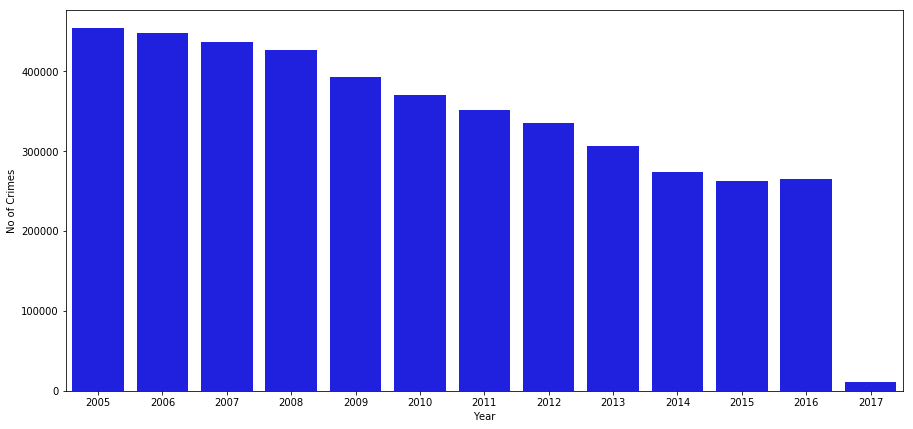

In [23]:
sns.countplot(x='Year',data=crimedata, color=('BLUE'))
fig = plt.gcf()
plt.ylabel('No of Crimes')
fig.set_size_inches(15,7)

plt.show()

<img src="https://i.imgur.com/NKCXP7C.png" align="left">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:orange; padding: 1em;">
We can see that the crime rate has been falling each year, but have a dramatic drop off from the year 2008 to 2014. We need to investigate further to find the reason for this steep decline.<br>

<p id="Community_areas"><b> <font size="+2"> Number of incidents per Community areas </font> </b></p>

<img src="https://i.imgur.com/VgE45Xt.png" align="right">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:blue; padding: 1em;">
The Social Science Research Committee at the University of Chicago have been defined community areas during the late 1920s.<br><br>
<b>Community areas data</b> can be found here <a href="https://data.cityofchicago.org/d/cauq-8yn6">Community areas</a></p>

In [24]:
Community_Areas_geo = r'../input/chicago-community-areas/Chicago_Community_Areas.geojson'
# Community_Areas map 2016
Community_Areas_data2016 = pd.DataFrame(crimedata2016['community_area'].value_counts().astype(float))
Community_Areas_data2016.to_json('Community_Area_Map2016.json')
Community_Areas_data2016 = Community_Areas_data2016.reset_index()
Community_Areas_data2016.columns = ['community_area', 'Crime_Count']


map2016 = folium.Map(location=Chicago_COORDINATES, zoom_start=11)
#map2016.add_child(feature_group)
#map8.add_children(folium.map.LayerControl())

map2016.choropleth(geo_data = Community_Areas_geo,
                data = Community_Areas_data2016,
                columns = ['community_area', 'Crime_Count'],
                key_on = "feature.properties.area_numbe",
                fill_color = 'YlOrRd', 
                fill_opacity = 0.7, 
                line_opacity = 0.2,
                threshold_scale=[0, 4000, 8000, 12000, 16000, 20000],
                legend_name = 'Number of incidents per community area 2016')
               

folium.TileLayer('cartodbdark_matter').add_to(map2016)
folium.TileLayer('Stamen Terrain').add_to(map2016)
folium.TileLayer('Stamen Toner').add_to(map2016)
folium.TileLayer('Mapbox Bright').add_to(map2016)


#Marker coordnate for each Comunity area

# Next time use loop, you dummy
# you you Super Dummy
feature_group = FeatureGroup(name='Comunity area number')
feature_group.add_child(Marker([42.01,-87.67],'Comunity area 1, ROGERS PARK'))
feature_group.add_child(Marker([42.0, -87.70],'Comunity area 2, WEST RIDGE'))
feature_group.add_child(Marker([41.965,-87.655],'Comunity area 3, UPTOWN'))
feature_group.add_child(Marker([41.975, -87.685],'Comunity area 4, LINCOLN SQUARE'))
feature_group.add_child(Marker([41.95, -87.685],'Comunity area 5, NORTH CENTER'))
feature_group.add_child(Marker([41.94, -87.655],'Comunity area 6, LAKE VIEW'))
feature_group.add_child(Marker([41.92, -87.655],'Comunity area 7, LINCOLN PARK'))
feature_group.add_child(Marker([41.9, -87.632],'Comunity area 8, NEAR NORTH SIDE'))
feature_group.add_child(Marker([42.006, -87.815],'Comunity area 9, EDISON PARK'))
feature_group.add_child(Marker([41.987, -87.8],'Comunity area 10, NORWOOD PARK'))
feature_group.add_child(Marker([41.98, -87.769],'Comunity area 11, JEFFERSON PARK'))
feature_group.add_child(Marker([41.987, -87.752],'Comunity area 12, FOREST GLEN'))
feature_group.add_child(Marker([41.985, -87.72],'Comunity area 13, NORTH PARK'))
feature_group.add_child(Marker([41.965, -87.72],'Comunity area 14, ALBANY PARK'))
feature_group.add_child(Marker([41.95, -87.764],'Comunity area 15, PORTAGE PARK'))
feature_group.add_child(Marker([41.954, -87.725],'Comunity area 16, IRVING PARK'))
feature_group.add_child(Marker([41.945, -87.808],'Comunity area 17, DUNNING'))
feature_group.add_child(Marker([41.927, -87.8],'Comunity area 18, MONTCLARE'))
feature_group.add_child(Marker([41.925, -87.765],'Comunity area 19, BELMONT CRAGIN'))
feature_group.add_child(Marker([41.925, -87.73501],'Comunity area 20, HERMOSA'))
feature_group.add_child(Marker([41.938, -87.71],'Comunity area 21, AVONDALE'))
feature_group.add_child(Marker([41.923, -87.7],'Comunity area 22, LOGAN SQUARE'))
feature_group.add_child(Marker([41.9, -87.725],'Comunity area 23, HUMBOLDT PARK'))
feature_group.add_child(Marker([41.9, -87.685],'Comunity area 24, WEST TOWN'))
feature_group.add_child(Marker([41.89, -87.761],'Comunity area 25, AUSTIN'))
feature_group.add_child(Marker([41.878, -87.729],'Comunity area 26, WEST GARFIELD PARK'))
feature_group.add_child(Marker([41.878, -87.705],'Comunity area 27, EAST GARFIELD PARK'))
feature_group.add_child(Marker([41.874, -87.665],'Comunity area 28, NEAR WEST SIDE'))
feature_group.add_child(Marker([41.861, -87.714],'Comunity area 29, NORTH LAWNDALE'))
feature_group.add_child(Marker([41.84, -87.714],'Comunity area 30, SOUTH LAWNDALE'))
feature_group.add_child(Marker([41.85, -87.664],'Comunity area 31, LOWER WEST SIDE'))
feature_group.add_child(Marker([41.876, -87.627],'Comunity area 32, LOOP'))
feature_group.add_child(Marker([41.8555, -87.6199],'Comunity area 33, NEAR SOUTH SIDE'))
feature_group.add_child(Marker([41.84, -87.633],'Comunity area 34, ARMOUR SQUARE'))
feature_group.add_child(Marker([41.834, -87.6199],'Comunity area 35, DOUGLA'))
feature_group.add_child(Marker([41.824, -87.602],'Comunity area 36, OAKLAND'))
feature_group.add_child(Marker([41.811, -87.632],'Comunity area 37, FULLER PARK'))
feature_group.add_child(Marker([41.811, -87.617],'Comunity area 38, GRAND BOULEVARD'))
feature_group.add_child(Marker([41.809, -87.595],'Comunity area 39, KENWOOD'))
feature_group.add_child(Marker([41.792, -87.617],'Comunity area 40, WASHINGTON PARK'))
feature_group.add_child(Marker([41.792, -87.595],'Comunity area 41, HYDE PARK'))
feature_group.add_child(Marker([41.78, -87.595],'Comunity area 42, WOODLAWN'))
feature_group.add_child(Marker([41.763, -87.575],'Comunity area 43, SOUTH SHORE'))
feature_group.add_child(Marker([41.738, -87.615],'Comunity area 44, CHATHAM'))
feature_group.add_child(Marker([41.742, -87.589],'Comunity area 45, AVALON PARK'))
feature_group.add_child(Marker([41.739, -87.548],'Comunity area 46, SOUTH CHICAGO'))
feature_group.add_child(Marker([41.728, -87.597],'Comunity area 47, BURNSIDE'))
feature_group.add_child(Marker([41.73, -87.575],'Comunity area 48, CALUMET HEIGHTS'))
feature_group.add_child(Marker([41.709, -87.619],'Comunity area 49, ROSELAND'))
feature_group.add_child(Marker([41.703, -87.598],'Comunity area 50, PULLMAN'))
feature_group.add_child(Marker([41.692, -87.568],'Comunity area 51, SOUTH DEERING'))
feature_group.add_child(Marker([41.71, -87.535],'Comunity area 52, EAST SIDE'))
feature_group.add_child(Marker([41.672, -87.628],'Comunity area 53, WEST PULLMAN'))
feature_group.add_child(Marker([41.658, -87.603],'Comunity area 54, RIVERDALE'))
feature_group.add_child(Marker([41.65, -87.54],'Comunity area 55, HEGEWISCH'))
feature_group.add_child(Marker([41.792, -87.77],'Comunity area 56, GARFIELD RIDGE'))
feature_group.add_child(Marker([41.809, -87.726],'Comunity area 57, ARCHER HEIGHTS'))
feature_group.add_child(Marker([41.815, -87.70],'Comunity area 58, BRIGHTON PARK'))
feature_group.add_child(Marker([41.83, -87.672],'Comunity area 59, MCKINLEY PARK'))
feature_group.add_child(Marker([41.836, -87.648],'Comunity area 60, BRIDGEPORT'))
feature_group.add_child(Marker([41.809, -87.657],'Comunity area 61, NEW CITY'))
feature_group.add_child(Marker([41.792, -87.726],'Comunity area 62, WEST ELSDON'))
feature_group.add_child(Marker([41.795, -87.695],'Comunity area 63, GAGE PARK'))
feature_group.add_child(Marker([41.778, -87.77],'Comunity area 64, CLEARING'))
feature_group.add_child(Marker([41.77, -87.726],'Comunity area 65, WEST LAWN'))
feature_group.add_child(Marker([41.77, -87.695],'Comunity area 66, CHICAGO LAWN'))
feature_group.add_child(Marker([41.775, -87.665],'Comunity area 67, WEST ENGLEWOOD'))
feature_group.add_child(Marker([41.775, -87.644],'Comunity area 68, ENGLEWOOD'))
feature_group.add_child(Marker([41.764, -87.622],'Comunity area 69, GREATER GRAND CROSSING'))
feature_group.add_child(Marker([41.744, -87.708],'Comunity area 70, ASHBURN'))
feature_group.add_child(Marker([41.742, -87.658],'Comunity area 71, AUBURN GRESHAM'))
feature_group.add_child(Marker([41.716, -87.673],'Comunity area 72, BEVERLY'))
feature_group.add_child(Marker([41.716, -87.648],'Comunity area 73, WASHINGTON HEIGHTS'))
feature_group.add_child(Marker([41.694, -87.708],'Comunity area 74, MOUNT GREENWOOD'))
feature_group.add_child(Marker([41.688, -87.67],'Comunity area 75, MORGAN PARK'))
feature_group.add_child(Marker([41.98, -87.91],'Comunity area 76, OHARE'))
feature_group.add_child(Marker([41.985, -87.665],'Comunity area 77, EDGEWATER'))

map2016.add_child(feature_group)
map2016.add_child(folium.map.LayerControl())
#map2016


/opt/conda/lib/python3.6/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning



<img src="https://i.imgur.com/fzorqjI.png" align="left">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:orange; padding: 1em;">
We finaly got folium marker and TileLayer to work!<br>
You can now click on the marker to find out the <b>comuntiy area number</b> and <b>name</b>.<br>
TileLayer can change the map display. It doesn't add any value to our anayltic, but it look super cool.</p>

<img src="https://i.imgur.com/FzsTGPb.png" align="left">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:orange; padding: 1em;">Dealing with date time is a real hassle and reading this short explanation doesn't really help. I highly recommend just messing around with the code on your own time.</p>

In [25]:
crimedata['Date'] = pd.to_datetime(crimedata['Date'],format='%m/%d/%Y %I:%M:%S %p')

In [26]:
import calendar
crimedata['Month']=(crimedata['Date'].dt.month).apply(lambda x: calendar.month_abbr[x])

In [27]:
crimedata['Month'] = pd.Categorical(crimedata['Month'] , categories=['Jan','Feb','Mar','Apr','May',
                                                'Jun','Jul','Aug','Sep','Oct','Nov','Dec'], ordered=True)

months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


<p style="border:4px; border-radius: 15px; border-style:solid; border-color:blue; padding: 1em;">
Here we are just converting <b>Date</b> column to <b>datetime</b> and than sorting it into month category. <br><img src="https://i.imgur.com/VgE45Xt.png" align="right">such as jan = 1 and dec = 12.<br><br>
From there we added a <b>Month</b> column. This will be used to make our visual later.<br><br>
Below you can see our newly made <b>Month</b> column</p>

In [28]:
crimedata.head(5)

ID                Date   Primary Type  ...  Community Area  Year Month
0  4673626 2006-04-02 13:00:00  OTHER OFFENSE  ...              11  2006   Apr
1  4673627 2006-02-26 13:40:48      NARCOTICS  ...              42  2006   Feb
2  4673628 2006-01-08 23:16:00        ASSAULT  ...              69  2006   Jan
3  4673629 2006-04-05 18:45:00        BATTERY  ...              17  2006   Apr
4  4673630 2006-02-17 21:03:14      NARCOTICS  ...              65  2006   Feb

[5 rows x 10 columns]

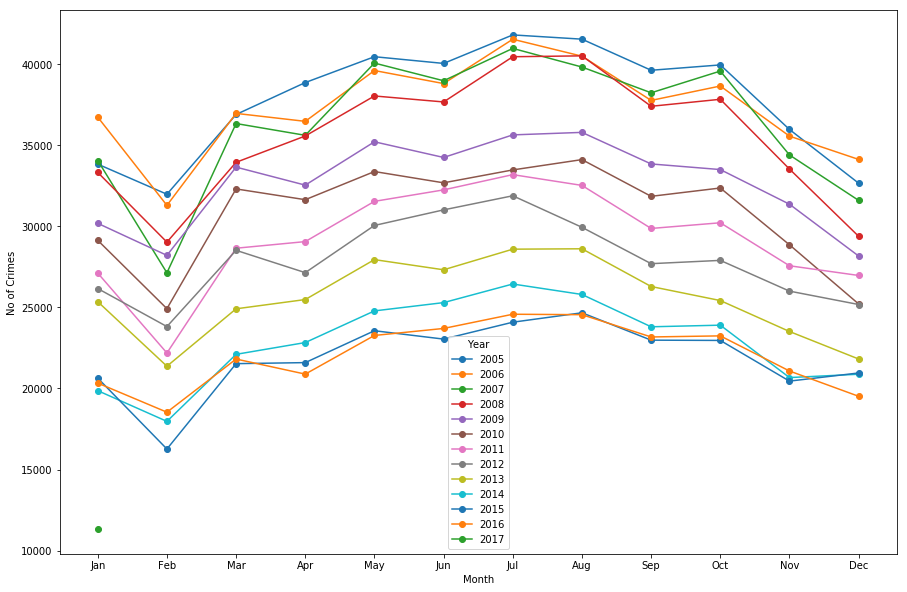

In [29]:
crimedata.groupby(['Month','Year'])['ID'].count().unstack().plot(marker='o', figsize=(15,10))
plt.xticks(np.arange(12),months)
plt.ylabel('No of Crimes')

plt.show()

<img src="https://i.imgur.com/NKCXP7C.png" align="left">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:orange; padding: 1em;">
When looking at the time-series graph, you'll notice two seasonal variations.<br><br>
1. February will have a serve drop in crime. We concluded that weather may have played a factor in the drop in crime. There is a strong correlation with lower temperature resulting in the lower crime rate.<br><br>
2. During summer time will have the most active crime recorded
</p>

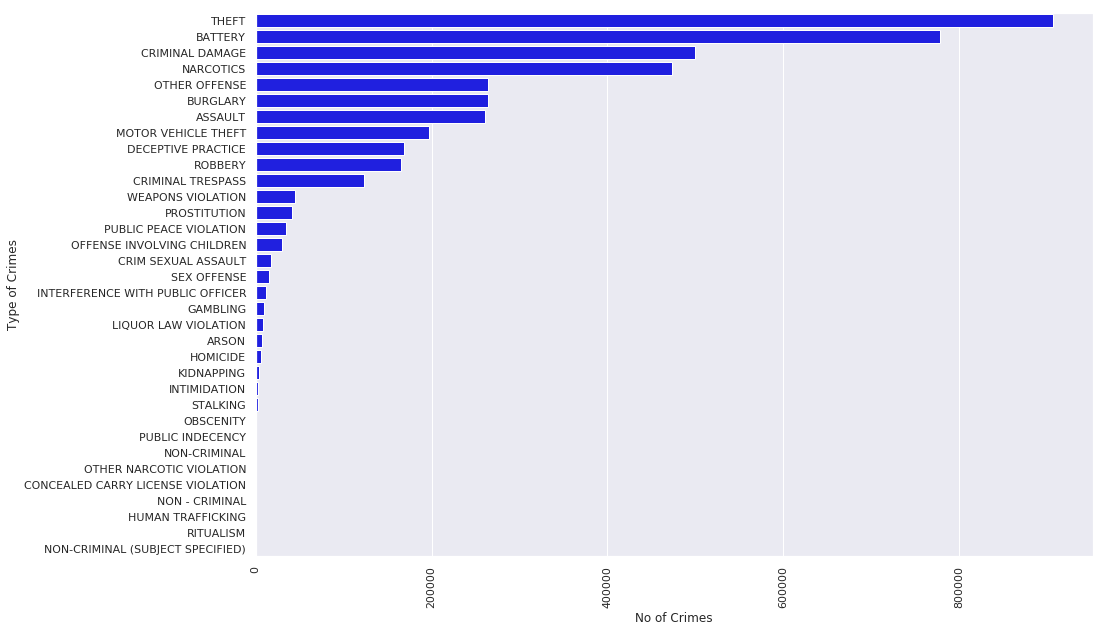

In [30]:
sns.set(rc={'figure.figsize':(15,10)})
sns.countplot(y='Primary Type',data=crimedata,order=crimedata['Primary Type'].value_counts().index, color=('BLUE'))
plt.xticks(rotation='vertical')
plt.xlabel('No of Crimes')
plt.ylabel('Type of Crimes')
plt.show()

<img src="https://i.imgur.com/VgE45Xt.png" align="right">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:blue; padding: 1em;">
Here we can see the top 6 crimes being commited in chicago is: <b>THEFT, BATTERY, CRIMINAL DAMAGE, NARCOTICS, BURGLARY</b> and<b>  ASSAULT</b><br>
By viewing when the crime is committed within the 24-hours day, we can better understand the behaviour and characteristics of each crime.</p>

In [31]:
df_crime=crimedata[(crimedata['Primary Type']=='THEFT')|(crimedata['Primary Type']=='BATTERY')|
                 (crimedata['Primary Type']=='CRIMINAL DAMAGE')|(crimedata['Primary Type']=='NARCOTICS')|
                 (crimedata['Primary Type']=='BURGLARY')|(crimedata['Primary Type']=='ASSAULT')]

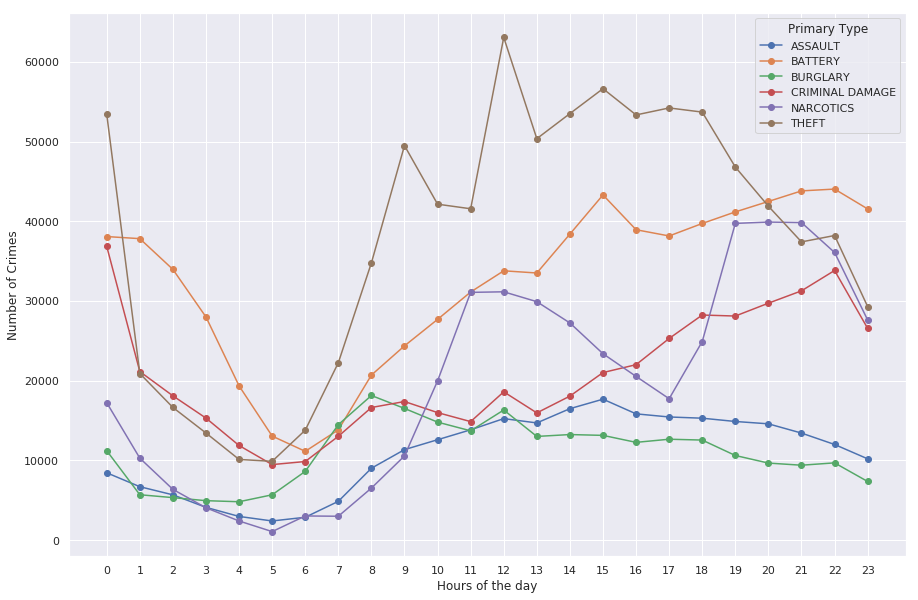

In [32]:
df_crime.groupby([df_crime['Date'].dt.hour,'Primary Type',])['ID'].count().unstack().plot(marker='o')
plt.ylabel('Number of Crimes')
plt.xlabel('Hours of the day')
plt.xticks(np.arange(24))
plt.show()

<img src="https://i.imgur.com/G7kDtAg.png" align="left">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:orange; padding: 1em;">
When looking at the time-series graph, you'll notice several trends in crime committed.<br><br>
Most crimes will start decline at 1 AM<br>
Lowest number of crime commited is between 5 AM and 6AM<br>
Highest number of theft reported is in the afternoon. "Stealing in broad daylight"<br>
Narcotics is shown to peak twice, once around the afternoon and again between 7 PM and 9 PM</p>

<p id="Narcotics"><center> <h1> <b> <font size="+3">Taking a closer look at Narcotics</font></b></h1></center></p>
<img src="https://i.imgur.com/4j9y1cF.png"><br>
<p>Crime for <b>NARCOTICS</b> behave much differently than the rest of the crime. we will be taking a closer look at the data.</p>

In [33]:
df_drug = crimedata[crimedata['Primary Type'] == 'NARCOTICS']

Text(0, 0.5, 'Type of Crimes')

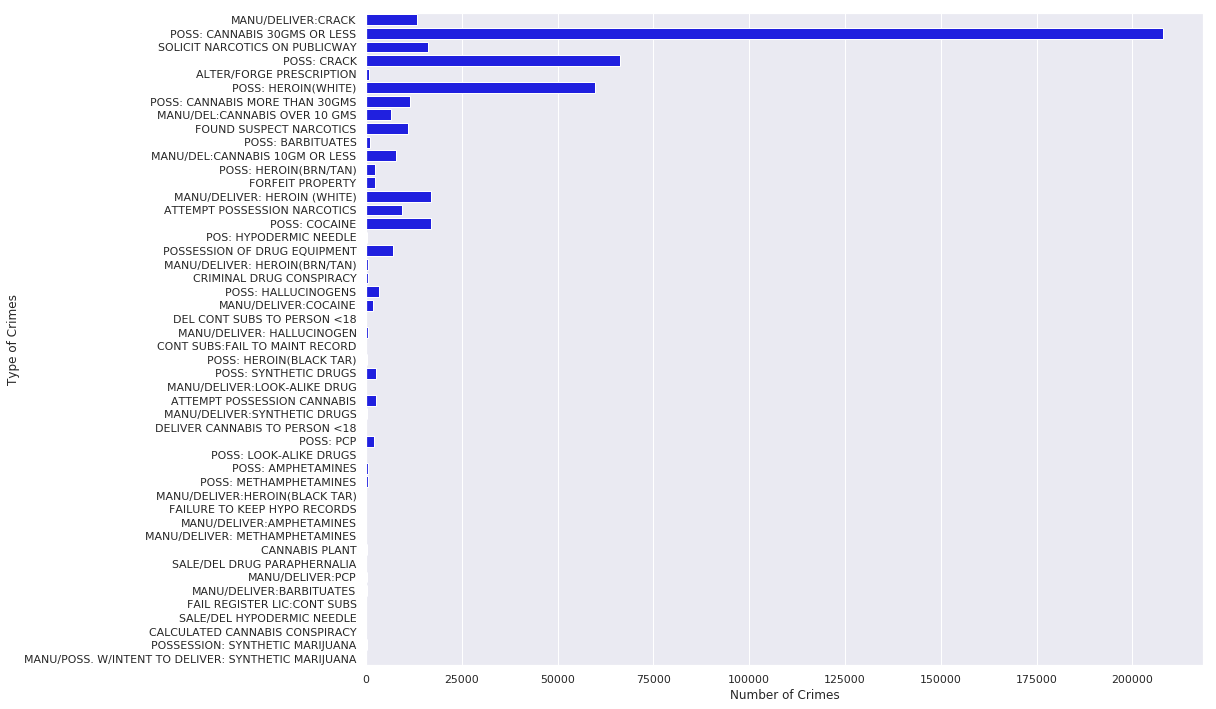

In [34]:
plt.figure(figsize = (15, 12))
sns.countplot(y = df_drug['Description'],color=("Blue"))
plt.xlabel('Number of Crimes')
plt.ylabel('Type of Crimes')

In [35]:
df_narcotic=crimedata[(crimedata['Description']=='POSS: CANNABIS 30GMS OR LESS')|(crimedata['Description']=='POSS: HEROIN(WHITE)')|
                    (crimedata['Description']=='POSS: CRACK')|(crimedata['Description']=='POSS: CANNABIS MORE THAN 30GMS')]

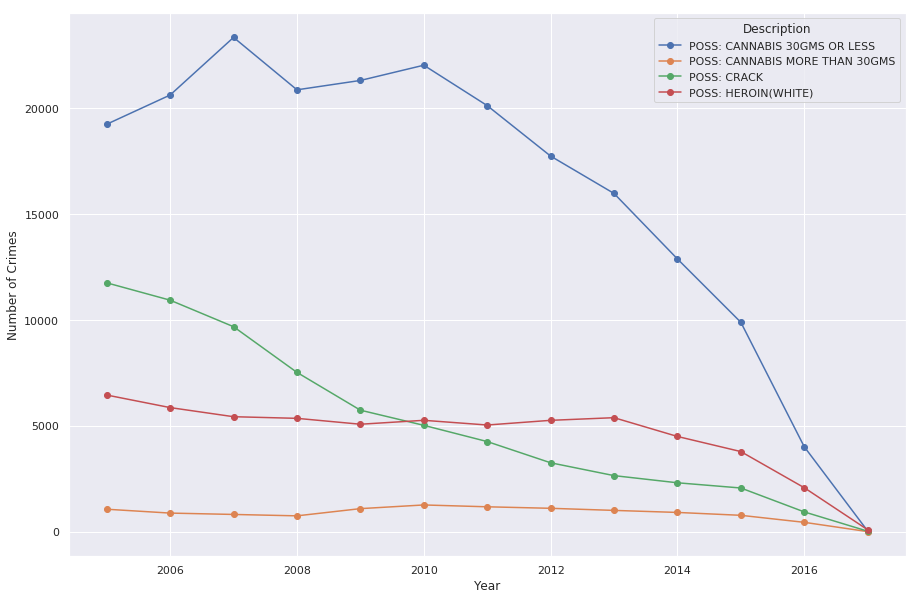

In [36]:
df_narcotic.groupby([df_narcotic['Date'].dt.year,'Description',])['ID'].count().unstack().plot(marker='o')
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
#plt.xticks(np.arange(1))
plt.show()

<img src="https://i.imgur.com/NKCXP7C.png" align="left">
<p style="border:4px; border-radius: 15px; border-style:solid; border-color:orange; padding: 1em;">
As you can see, the reported number of marijuana crimes has been dropping throughout the year.
Currently, Medical marijuana is legal in Illinois, but the recreational use of marijuana is not.
The State of Illinoise has pass a law to decriminalization possestion of marijuana.
</p>

In [37]:

na2016 = df_narcotic[df_narcotic["Year"]==2016]
na2016.columns = na2016.columns.str.strip().str.lower().str.replace(' ', '_')

In [38]:
na2016.shape

(7509, 10)

In [39]:
# Community_Areas map 2016
Community_Areas_data2016 = pd.DataFrame(na2016['community_area'].value_counts().astype(float))
Community_Areas_data2016.to_json('Community_Area_nMap2016.json')
Community_Areas_data2016 = Community_Areas_data2016.reset_index()
Community_Areas_data2016.columns = ['community_area', 'Crime_Count']


nmap2016 = folium.Map(location=Chicago_COORDINATES, zoom_start=11)
#map2016.add_child(feature_group)
#map8.add_children(folium.map.LayerControl())

nmap2016.choropleth(geo_data = Community_Areas_geo,
                data = Community_Areas_data2016,
                name='choropleth',
                columns = ['community_area', 'Crime_Count'],
                key_on = "feature.properties.area_numbe",
                fill_color = 'YlGn', 
                fill_opacity = 0.7, 
                line_opacity = 0.2,
                threshold_scale=[0, 500, 1000, 1500, 2000, 2500],
                legend_name = 'Number of incidents per community area 2016')
               

folium.TileLayer('cartodbdark_matter').add_to(nmap2016)
folium.TileLayer('Stamen Terrain').add_to(nmap2016)
folium.TileLayer('Stamen Toner').add_to(nmap2016)
folium.TileLayer('Mapbox Bright').add_to(nmap2016)

nmap2016.add_child(feature_group)
nmap2016.add_child(folium.map.LayerControl())
#map2016

/opt/conda/lib/python3.6/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


<p><b> <font size="+2"> Conclusion </font> </b></p>
<img src="https://i.imgur.com/iescrbs.png" align="left">